# Basic Instructions

1. Enter your Name, UID and Link to Google Drive in the provided space.
2. Submit the assignment to Gradescope.

Intermediate Submission Deadline: March 23, 5:00pm

Final Submission Deadline: March 27, 5:00pm

As before, submit your challenge file to ELMS.

Name:  **Sumedh Koppula**  
UID:  **117386066**

Link to Google Drive : **https://colab.research.google.com/drive/1MdnHYzYTKgTVMdcr2ShfkvXfsq-ESsVb?usp=sharing**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

## Dataset and Preprocessing

For this assignment, we will use the following dataset, which contains images of animals and such with segmentations.

In [ ]:
#For deleting the dataset
!rm -r SegmentationDataset/

In [ ]:
#Use this to download if not using colab
download_link='https://drive.google.com/file/d/1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn/view?usp=sharing'

#If using colab dataset can be downloaded using this command
!gdown --id 1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn
!unzip --qq SegmentationDataset.zip

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn
To: /content/SegmentationDataset.zip
100% 44.1M/44.1M [00:00<00:00, 200MB/s]


In [ ]:
%matplotlib inline
import cv2
import os
import torch.utils.data as data
from torchvision import transforms
import _pickle as pickle
import torchvision.models as models
import glob

current_directory = os.getcwd()
msrc_directory = current_directory + '/SegmentationDataset'

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """

    plt.figure()
    if(im.shape[2]==1):
        plt.imshow(np.squeeze(im),cmap='gray')
    elif cv2:
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)


In [ ]:
# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

background_classes=["void","grass","sky"]
background_colors=[]
for i in range(len(SEG_LABELS_LIST_v1)):
    if SEG_LABELS_LIST_v1[i]["name"] in background_classes:
        background_colors.append(SEG_LABELS_LIST_v1[i]["rgb_values"])



def get_binary_seg(bgr_seg):
    rgb_seg=bgr_seg#[:,:,::-1]#reverse order of channels from bgr to rgb
    shape_rgb=rgb_seg.shape
    binary_shape=(shape_rgb[0],shape_rgb[1],1)

    binary_map=np.ones( binary_shape )
    for background_color in background_colors:
        binary_map[(rgb_seg==background_color).all(2)]=0

    return binary_map

Here are some examples.

<class 'numpy.ndarray'>
(213, 320, 3)


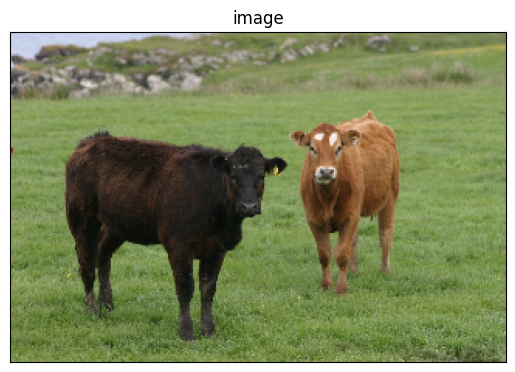

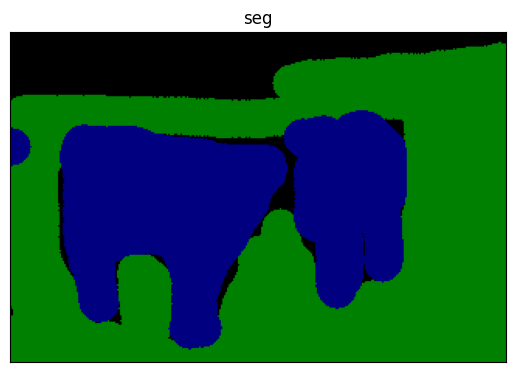

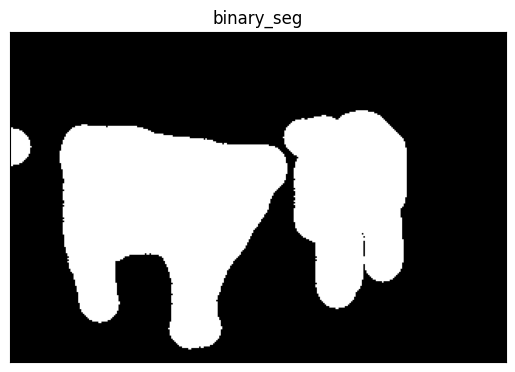

In [ ]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('SegmentationDataset/train/1_19_s.bmp')
seg_sample = cv2.imread('SegmentationDataset/train/1_19_s_GT.bmp')
print(type(seg_sample))
print(seg_sample.shape)
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')
plot_image(get_binary_seg(seg_sample), 'binary_seg')

Here we provide you with a Dataset and dataloaders.

---



In [ ]:
class SegmentationData(data.Dataset):
    #168:48:24 split
    def __init__(self, img_transform, mask_transform, mode='train'):
        if mode not in ['train','test','val']:
            raise ValueError('Invalid Split %s' % mode)
        self.mode = mode
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.img_list_train_val = [x.split('.')[-2].split('/')[-1][:-3] for x in glob.glob(msrc_directory+'/train/*') if 'GT' in x]
        self.img_list_train_val.sort()
        self.img_list_test = [x.split('.')[-2].split('/')[-1] for x in glob.glob(msrc_directory+'/test/*')]
        self.img_list_test.sort()

        self.x={}
        self.y={}
        self.x['train'] = ['%s/%s.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[:168]]
        self.y['train'] = ['%s/%s_GT.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[:168]]
        self.x['val'] = ['%s/%s.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[168:]]
        self.y['val'] = ['%s/%s_GT.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[168:]]
        self.x['test'] = ['%s/%s.bmp' %(msrc_directory+'/test',x) for x in self.img_list_test]

    def __len__(self):
        return len(self.x[self.mode])

    def __getitem__(self, index):
      if self.mode in ['train', 'val']:
          img = Image.open(self.x[self.mode][index]).convert('RGB')
          mask = get_binary_seg(np.array(Image.open(self.y[self.mode][index]).convert('RGB')))#.astype(np.int)
          mask = np.squeeze(mask.astype(np.uint8), axis=2)*255
          mask = Image.fromarray(mask)
          tensor_img = self.img_transform(img)
          tensor_mask = self.mask_transform(mask)
          return tensor_img,tensor_mask
      else:
          img = Image.open(self.x[self.mode][index]).convert('RGB')
          tensor_img = self.img_transform(img)
          return tensor_img


img_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
mask_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='train')
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='val')
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)
test_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False)

For convenience, here's an example of how to use these dataloaders.

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
<class 'torch.Tensor'>
torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
torch.Size([16, 3, 256, 256])


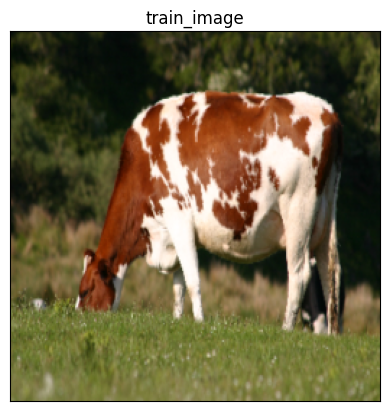

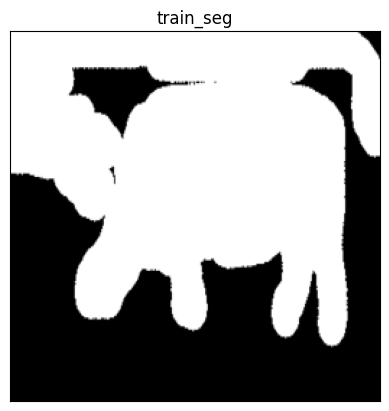

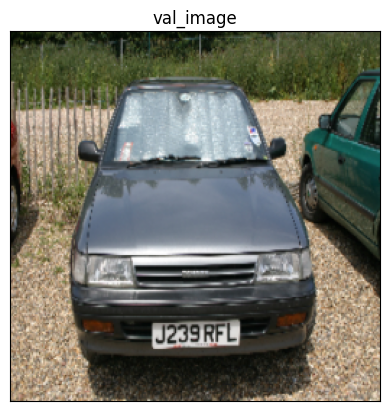

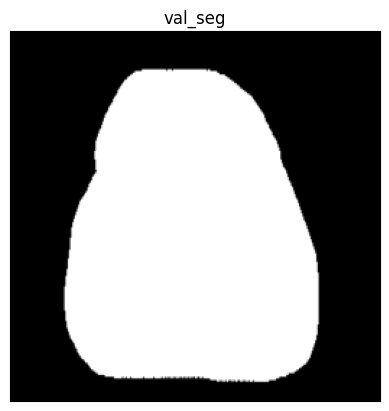

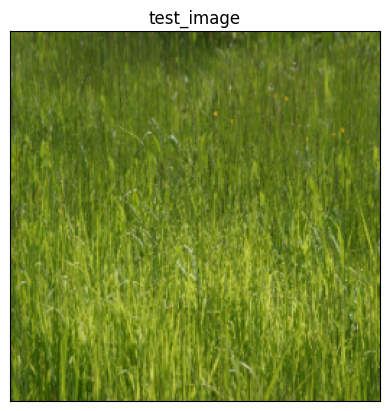

In [ ]:
input,labels = next(iter(train_dataloader))
print(input.shape,labels.shape)
print(type(input[2]))
img = input[2].numpy().transpose(1, 2, 0)
mask = labels[2].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'train_image', cv2=False)
plot_image(mask, 'train_seg')

input,labels = next(iter(val_dataloader))
print(input.shape,labels.shape)
img = input[2].numpy().transpose(1, 2, 0)
mask = labels[2].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'val_image', cv2=False)
plot_image(mask, 'val_seg')

input = next(iter(test_dataloader))
print(input.shape)
img = input[2].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'test_image', cv2=False)

## 1. Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to perform these segmentations, where we need to distinguish foreground from background, where the class of interest is considered foreground.

###  U-Net

<img src="https://www.researchgate.net/profile/Alan-Jackson-2/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png" style="width:650px;height:400px;">

A U-Net is an end-to-end segmentation network that should work reasonably well in this low data setting. It will take an image, progressively convolve it to a collection of many small feature maps, and then progressively up-convolve the maps while combining with crops from the previous layers. The figure provided gives an excellent example of a baseline U-Net that you can use as a starting point.

For these operations, use ```nn.Conv2d```, ```torch.cat```, and ```nn.ConvTranspose2d```, ```nn.MaxPool2d```. You may find it useful to use ```nn.BatchNorm2d``` as well.

Note that you can experiment with different channel sizes. Try to start with something smaller than 112, like 16.

Let's now implement those the model!

In [ ]:
import torch.nn.init as init

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    self.conv1 = self.double_conv_layer(3, 32)
    self.conv2 = self.double_conv_layer(32, 64)
    self.conv3 = self.double_conv_layer(64, 128)
    self.conv4 = self.double_conv_layer(128, 256)
    self.dropout = nn.Dropout2d(p=0.6)
    self.maxpool = nn.MaxPool2d(2, 2)
    self.conv5 = self.double_conv_layer(256,256)
    self.upconv5 = torch.nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
    self.conv6 = self.double_conv_layer(512,128)
    self.upconv6 = torch.nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
    self.conv7 = self.double_conv_layer(256,64)
    self.upconv7 = torch.nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
    self.conv8 = self.double_conv_layer(128,32)
    self.upconv8 = torch.nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.conv9 = self.double_conv_layer(64,32)
    self.output = nn.Conv2d(32,1, kernel_size=1)
    self.sigmoid = nn.Sigmoid()


  def initialize_weights(net):
    """Initialize the weights of the network using xavier initialization."""
    for m in net.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0.0)

  def double_conv_layer(self, input_channels, output_channels, kernel_size=3, padding=1):
    """Returns a double convolution layer with batch normalization and ReLU activation."""
    return nn.Sequential(
        # convolution layer with stride 1 and padding
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=1, padding=padding),
        # batch normalization
        nn.BatchNorm2d(output_channels),
        # ReLU activation
        nn.ReLU(inplace=True),
        # convolution layer with kernel size 3, stride 1 and padding 1
        nn.Conv2d(output_channels, output_channels, kernel_size=kernel_size, stride=1, padding=padding),
        # batch normalization
        nn.BatchNorm2d(output_channels),
        # ReLU activation
        nn.ReLU(inplace=True)
    )

  def forward(self, input):
    """Forward pass of the network."""

    # ENCODER
    block_1 = self.conv1(input)
    maxpool_1 = self.maxpool(block_1)
    block_2 = self.conv2(maxpool_1)
    maxpool_2 = self.maxpool(block_2)
    block_3 = self.conv3(maxpool_2)
    maxpool_3 = self.maxpool(block_3)
    block_4 = self.conv4(maxpool_3)
    maxpool_4 = self.maxpool(block_4)

    block_5 = self.conv5(maxpool_4)
    block_5 = self.upconv5(block_5)

    # DECODER
    # CONCATENATE block_4 and block_5
    block_5 = torch.cat([block_5, block_4], 1)
    block_5 = self.dropout(block_5)

    block_6 = self.conv6(block_5)
    block_6 = self.upconv6(block_6)

    # CONCATENATE block_3 and block_6
    block_6 = torch.cat([block_6, block_3], 1)
    block_6 = self.dropout(block_6)

    block_7 = self.conv7(block_6)
    block_7 = self.upconv7(block_7)

    # CONCATENATE block_2 and block_7
    block_7 = torch.cat([block_7, block_2], 1)
    block_7 = self.dropout(block_7)

    block_8 = self.conv8(block_7)
    block_8 = self.upconv8(block_8)

    # CONCATENATE block_1 and block_8
    block_8 = torch.cat([block_8, block_1], 1)
    block_8 = self.dropout(block_8)

    block_9 = self.conv9(block_8)
    output = self.output(block_9)

    # sigmoid activation
    output = self.sigmoid(output)
    return output



## 2. Defining the for loop for train and validation phase

### In each the phases certain things one has to be careful of:

- Training Phase:
  - Make sure the model is in train mode. That is ensured by `model.train()`

  - While looping over instances of a batch, make sure the graidents are always set to zero before calling the backward function. That's done by `optim.zero_grad()`. If this is not done, the gradients get accumulated.

  - Call the backward function on the loss by `loss.backward()` so that the loss get back propagated.

  - Call the step function of the optimiser to update the weights of the network. This is done by `optim.step()`

- Validation/Testing Phase
  - Make sure your model is in eval mode. This makes the model deterministic rather than probabilistic. This is ensured by `model.eval()`
  - As we don't need any gradients doing our validation/ testing phase, we can esnure that they are not calculated by defining a block with `torch.no_grad()`

In [ ]:
model = UNet()
#UNet.initialize_weights(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
learning_rate = 0.0001 # Add learning rate
batch_size = 16 # Add batch size
epochs = 20
criterion = nn.BCELoss() # Add binary cross entropy loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, batch_size):
    train_loss_ = []
    val_loss_ = []
    train_accuracy_ = []
    val_accuracy_ = []
    for epoch in range(epochs):
        train_accurate_labels, train_total_labels = 0., 0.
        val_accurate_labels, val_total_labels = 0., 0.
        train_accuracy = 0.
        model.train()
        train_epoch_loss = 0
        train_loss = []
        val_loss = []
        for i, (inputs, labels) in enumerate(train_loader):
            # Set batch size for current epoch
            if i == len(train_loader) - 1:
                batch_size = len(inputs)
            else:
                batch_size = train_loader.batch_size

            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate loss for current epoch
            train_loss.append(loss.item())
            predictions = (outputs > 0.5).float()
            true_predictions = (predictions == labels).float().sum()
            train_accurate_labels += true_predictions.item()
            train_total_labels += labels.numel()

        train_accuracy += train_accurate_labels / train_total_labels
        train_accuracy_.append(train_accuracy)
        train_loss = np.mean(train_loss)
        train_loss_.append(np.mean(train_loss))




        model.eval()
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())

            predictions = (outputs > 0.5).float()
            true_predictions = (predictions == labels).float().sum()
            val_accurate_labels += true_predictions.item()
            val_total_labels += labels.numel()

        val_accuracy = val_accurate_labels / val_total_labels
        val_accuracy_.append(val_accuracy)
        val_loss = np.mean(val_loss)
        scheduler.step(val_loss)
        val_loss_.append(np.mean(val_loss))

        def accuracy(model, loader, device):
            correct = 0
            total = 0
            with torch.no_grad():
                for i, (inputs, labels) in enumerate(loader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    outputs = (outputs > 0.5).float()
                    correct += (outputs == labels).sum().item()
                    total += labels.numel()
            return correct / total

        # train and val accuracy
        train_acc = accuracy(model, train_loader, device)
        val_acc = accuracy(model, val_loader, device)

        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')

    return train_loss_, val_loss_, train_accuracy_, val_accuracy_

train_loss_, val_loss_, train_accuracy_, val_accuracy_ = train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs, device, batch_size)




Epoch: 1/20, Train Loss: 0.6853, Val Loss: 0.6870, Train Accuracy: 0.3801, Val Accuracy: 0.5563
Epoch: 2/20, Train Loss: 0.6500, Val Loss: 0.6895, Train Accuracy: 0.6274, Val Accuracy: 0.4958
Epoch: 3/20, Train Loss: 0.6218, Val Loss: 0.6814, Train Accuracy: 0.6324, Val Accuracy: 0.5270
Epoch: 4/20, Train Loss: 0.5909, Val Loss: 0.6487, Train Accuracy: 0.6962, Val Accuracy: 0.6321
Epoch: 5/20, Train Loss: 0.5549, Val Loss: 0.6148, Train Accuracy: 0.7808, Val Accuracy: 0.6813
Epoch: 6/20, Train Loss: 0.5155, Val Loss: 0.6037, Train Accuracy: 0.7891, Val Accuracy: 0.6828
Epoch: 7/20, Train Loss: 0.4896, Val Loss: 0.5918, Train Accuracy: 0.8238, Val Accuracy: 0.6947
Epoch: 8/20, Train Loss: 0.4633, Val Loss: 0.5898, Train Accuracy: 0.8309, Val Accuracy: 0.6973
Epoch: 9/20, Train Loss: 0.4431, Val Loss: 0.6151, Train Accuracy: 0.8529, Val Accuracy: 0.6770
Epoch: 10/20, Train Loss: 0.4073, Val Loss: 0.6320, Train Accuracy: 0.8669, Val Accuracy: 0.6421
Epoch 00011: reducing learning rate of 

## 3. Challenge Submission
Evaluate on the test set, and save the resulting segmentations in the same format as those in the initial dataset.
Your challenge results should be saved in a torch file with the same format as in A3, with shape (24, 256, 256), where all values are either 1 (foreground) or 0 (background).

In [ ]:
# Evaluate on the test set, and save the resulting segmentations in the same format as those in the initial dataset.
#Your challenge results should be saved in a torch file with the same format as in A3, with shape (24, 256, 256), where all values are either 1 (foreground) or 0 (background).

# Evaluate on test set
model.eval()
test_preds = []
for i, (inputs) in enumerate(test_dataloader):
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
    outputs = (outputs > 0.5).float()
    test_preds.append(outputs)

# shape (24, 256, 256)
test_preds = torch.cat(test_preds, dim=0)

# convert shape to (24, 256, 256)
test_preds = np.squeeze(test_preds, axis=1)
print(test_preds.shape)

# Save predictions
torch.save(test_preds, 'CEO_Mr_Robot.pth')


torch.Size([24, 256, 256])


Use this code to check your submission file:

In [ ]:
masks = torch.load('CEO_Mr_Robot.pth')

assert(masks.shape == (24, 256, 256))
assert((torch.where(masks == 1, 10, 0).sum() + torch.where(masks == 0, 10, 0).sum()).item() == 24 * 256 * 256 * 10)

## Analysis



### 4. Plot training and validation loss per batch

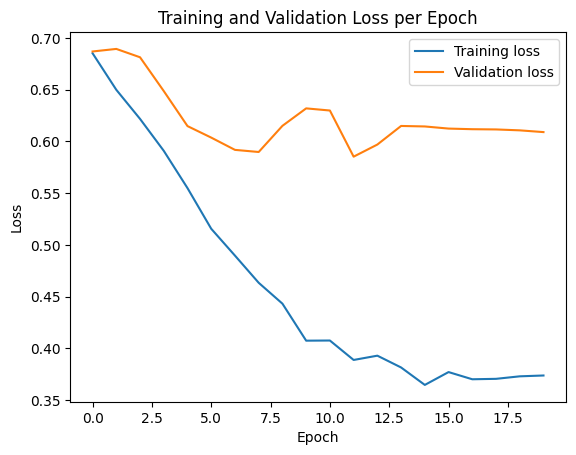

In [ ]:
plt.plot(train_loss_, label='Training loss')
plt.plot(val_loss_, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

### 5. Plot training and validation per-pixel accuracy per epoch

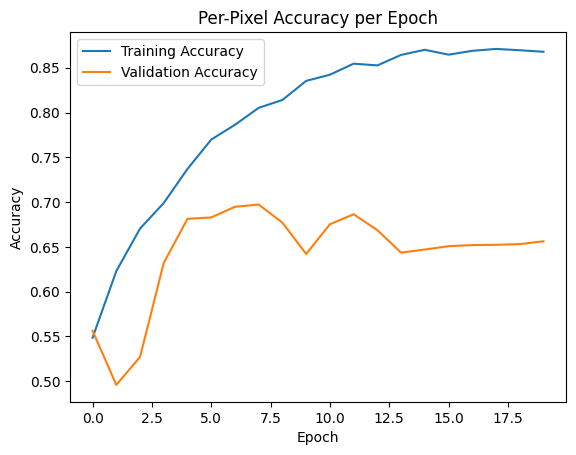

In [ ]:
plt.plot(train_accuracy_, label='Training Accuracy')
plt.plot(val_accuracy_, label='Validation Accuracy')
plt.title('Per-Pixel Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 6. Show segmentation result for 3 test images



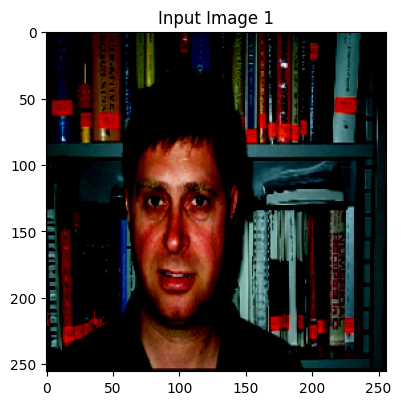

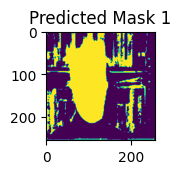

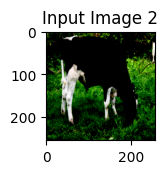

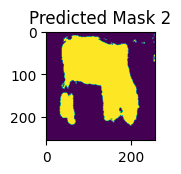

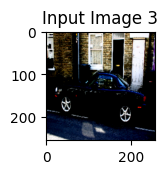

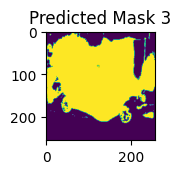

In [ ]:
import matplotlib.pyplot as plt
import random

def imshow(inp, title=None):
    inp = inp.cpu().numpy()
    if inp.ndim == 3:
        inp = inp.transpose((1, 2, 0))
        inp = np.clip(inp, 0, 1)  # Clip the input values to the valid range
    elif inp.ndim == 2:
        inp = inp.squeeze()
    else:
        raise ValueError("Unsupported number of dimensions in the input tensor")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)



test_iter = iter(test_dataloader)
num_images = 3
random_indices = random.sample(range(len(test_set)), num_images)

random_inputs = []
random_labels = []

for idx in random_indices:
    input_img = test_set[idx]
    random_inputs.append(input_img.unsqueeze(0))

random_inputs = torch.cat(random_inputs).to(device)

# Make sure that the model is in evaluation mode
model.eval()

# Perform a forward pass through the model
with torch.no_grad():
    outputs = model(random_inputs)

# Apply threshold to the output
threshold = 0.5
outputs = (outputs > threshold).float()

# Display the selected input images, ground truth masks, and predicted masks
fig = plt.figure(figsize=(15, 15))

for i in range(num_images):
    # Display input image
    plt.subplot(num_images, 3, i * 3 + 1)
    imshow(random_inputs[i], title=f'Input Image {i+1}')

    # Display predicted mask
    plt.subplot(num_images, 3, i * 3 + 3)
    imshow(outputs[i].cpu().squeeze(0), title=f'Predicted Mask {i+1}')

plt.show()
